In [1]:
import warnings

warnings.filterwarnings('ignore')

In [2]:
import pathlib

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import ModelCheckpoint

print(tf.__version__)

2.9.1


In [3]:
dataset_path = keras.utils.get_file(
    "auto-mpg.data",
    "http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data"
)
dataset_path

'C:\\Users\\HP\\.keras\\datasets\\auto-mpg.data'

In [4]:
column_names = [
    'MPG', 'Cylinders', 'Displacement', 'Horsepower', 'Weight', 'Acceleration',
    'Model Year', 'Origin'
]
raw_dataset = pd.read_csv(dataset_path,
                          names=column_names,
                          na_values="?",
                          comment='\t',
                          sep=" ",
                          skipinitialspace=True)

dataset = raw_dataset.copy()
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
393,27.0,4,140.0,86.0,2790.0,15.6,82,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,2
395,32.0,4,135.0,84.0,2295.0,11.6,82,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,1


In [5]:
dataset.isna().sum()

MPG             0
Cylinders       0
Displacement    0
Horsepower      6
Weight          0
Acceleration    0
Model Year      0
Origin          0
dtype: int64

In [6]:
dataset = dataset.dropna()

In [7]:
origin = dataset.pop('Origin')

In [8]:
# 더미 변수화, OneHotEncoding
dataset['USA'] = (origin == 1) * 1.0
dataset['Europe'] = (origin == 2) * 1.0
dataset['Japan'] = (origin == 3) * 1.0
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,USA,Europe,Japan
393,27.0,4,140.0,86.0,2790.0,15.6,82,1.0,0.0,0.0
394,44.0,4,97.0,52.0,2130.0,24.6,82,0.0,1.0,0.0
395,32.0,4,135.0,84.0,2295.0,11.6,82,1.0,0.0,0.0
396,28.0,4,120.0,79.0,2625.0,18.6,82,1.0,0.0,0.0
397,31.0,4,119.0,82.0,2720.0,19.4,82,1.0,0.0,0.0


In [9]:
# Split train:test, 8:2
train_dataset = dataset.sample(frac=0.8, random_state=0)
test_dataset = dataset.drop(train_dataset.index)

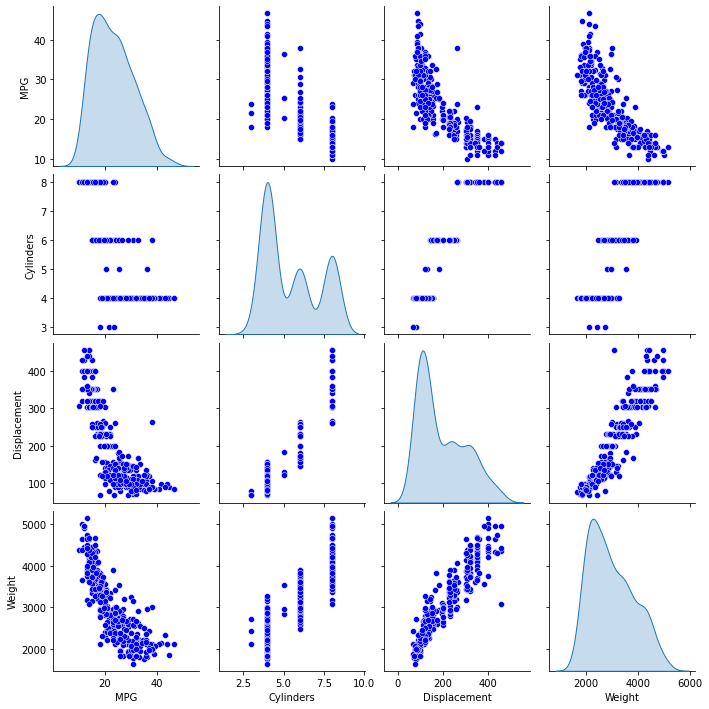

In [10]:
sns.pairplot(train_dataset[["MPG", "Cylinders", "Displacement", "Weight"]],
             diag_kind="kde",
             plot_kws={'color': 'b'})

In [11]:
train_stats = train_dataset.describe()
train_stats.pop("MPG")
train_stats = train_stats.transpose()
train_stats

,count,mean,std,min,25%,50%,75%,max
Cylinders,314.0,5.477707,1.699788,3.0,4.00,4.0,8.00,8.0
Displacement,314.0,195.318471,104.331589,68.0,105.50,151.0,265.75,455.0
Horsepower,314.0,104.869427,38.096214,46.0,76.25,94.5,128.00,225.0
Weight,314.0,2990.251592,843.898596,1649.0,2256.50,2822.5,3608.00,5140.0
Acceleration,314.0,15.559236,2.789230,8.0,13.80,15.5,17.20,24.8
Model Year,314.0,75.898089,3.675642,70.0,73.00,76.0,79.00,82.0
USA,314.0,0.624204,0.485101,0.0,0.00,1.0,1.00,1.0
Europe,314.0,0.178344,0.383413,0.0,0.00,0.0,0.00,1.0
Japan,314.0,0.197452,0.398712,0.0,0.00,0.0,0.00,1.0


In [12]:
train_labels = train_dataset.pop('MPG')
test_labels = test_dataset.pop('MPG')

In [13]:
def norm(x):
    return (x - train_stats['mean']) / train_stats['std']


normed_train_data = norm(train_dataset)
normed_test_data = norm(test_dataset)

In [14]:
def build_model():
    model = keras.Sequential([
        layers.Dense(64,
                     activation='relu',
                     input_shape=[len(train_dataset.keys())]),
        layers.Dense(64, activation='relu'),
        layers.Dense(1)
    ])

    optimizer = tf.keras.optimizers.RMSprop(0.001)

    model.compile(loss='mse', optimizer=optimizer, metrics=['mae', 'mse'])
    return model

In [15]:
model = build_model()

In [16]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                640       
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 4,865
Trainable params: 4,865
Non-trainable params: 0
_________________________________________________________________


In [17]:
example_batch = normed_train_data[:10]
example_result = model.predict(example_batch)
example_result

1/1 [==============================] - 0s 65ms/step


array([[0.3141399 ],
       [0.16458438],
       [1.1090684 ],
       [0.14873306],
       [0.12145582],
       [0.04246673],
       [0.18302602],
       [0.5298605 ],
       [0.09608124],
       [0.09342954]], dtype=float32)

In [18]:
# 에포크가 끝날 때마다 점(.)을 출력해 훈련 진행 과정을 표시합니다
class PrintDot(keras.callbacks.Callback):

    def on_epoch_end(self, epoch, logs):
        if epoch % 100 == 0: print('')
        print('.', end='')


# 모델 저장의 조건을 설정합니다.
modelpath = "./mpg/model/all/{epoch:04d}-{val_loss:.4f}.hdf5"
checkpointer = ModelCheckpoint(filepath=modelpath, verbose=1)

EPOCHS = 1000

history = model.fit(normed_train_data,
                    train_labels,
                    epochs=EPOCHS,
                    validation_split=0.2,
                    verbose=1,
                    callbacks=[checkpointer])

# 8/8은 배치사이즈 횟수를 의미
# 현재 자료는 train(314개 * fit할때 20%를 검증용으로 보냈으니 80%만 train) / 기본배치(32)
# 약 7.8로 배치1에 32개씩 8번 돌리면 train 314 * 80%의 갯수가 모두 실행됨
# 1/8, 2/8, ... 8/8
# 오버피팅 피하려면 배치사이즈를 키워야됨

Epoch 1/1000
1/8 [==>...........................] - ETA: 2s - loss: 471.2039 - mae: 20.7091 - mse: 471.2039
Epoch 1: saving model to ./mpg/model/all\0001-542.9053.hdf5
8/8 [==============================] - 0s 20ms/step - loss: 553.7656 - mae: 22.1470 - mse: 553.7656 - val_loss: 542.9053 - val_mae: 21.8062 - val_mse: 542.9053
Epoch 2/1000
1/8 [==>...........................] - ETA: 0s - loss: 454.0580 - mae: 20.4299 - mse: 454.0580
Epoch 2: saving model to ./mpg/model/all\0002-489.9236.hdf5
8/8 [==============================] - 0s 4ms/step - loss: 503.4512 - mae: 20.9154 - mse: 503.4512 - val_loss: 489.9236 - val_mae: 20.4681 - val_mse: 489.9236
Epoch 3/1000
1/8 [==>...........................] - ETA: 0s - loss: 368.0776 - mae: 17.5097 - mse: 368.0776
Epoch 3: saving model to ./mpg/model/all\0003-433.0341.hdf5
8/8 [==============================] - 0s 4ms/step - loss: 452.9200 - mae: 19.6163 - mse: 452.9200 - val_loss: 433.0341 - val_mae: 18.9606 - val_mse: 433.0341
Epoch 4/1000
1/8 [

8/8 [==============================] - 0s 5ms/step - loss: 8.6760 - mae: 2.1368 - mse: 8.6760 - val_loss: 9.8374 - val_mae: 2.4314 - val_mse: 9.8374
Epoch 27/1000
1/8 [==>...........................] - ETA: 0s - loss: 14.7884 - mae: 2.5185 - mse: 14.7884
Epoch 27: saving model to ./mpg/model/all\0027-9.6055.hdf5
8/8 [==============================] - 0s 5ms/step - loss: 8.3155 - mae: 2.0745 - mse: 8.3155 - val_loss: 9.6055 - val_mae: 2.4081 - val_mse: 9.6055
Epoch 28/1000
1/8 [==>...........................] - ETA: 0s - loss: 4.3627 - mae: 1.6322 - mse: 4.3627
Epoch 28: saving model to ./mpg/model/all\0028-9.5967.hdf5
8/8 [==============================] - 0s 4ms/step - loss: 8.1836 - mae: 2.0096 - mse: 8.1836 - val_loss: 9.5967 - val_mae: 2.3734 - val_mse: 9.5967
Epoch 29/1000
1/8 [==>...........................] - ETA: 0s - loss: 5.0947 - mae: 1.7658 - mse: 5.0947
Epoch 29: saving model to ./mpg/model/all\0029-9.9070.hdf5
8/8 [==============================] - 0s 4ms/step - loss: 7.9

Epoch 53/1000
1/8 [==>...........................] - ETA: 0s - loss: 5.0976 - mae: 1.7715 - mse: 5.0976
Epoch 53: saving model to ./mpg/model/all\0053-9.0848.hdf5
8/8 [==============================] - 0s 5ms/step - loss: 6.9819 - mae: 1.9093 - mse: 6.9819 - val_loss: 9.0848 - val_mae: 2.2315 - val_mse: 9.0848
Epoch 54/1000
1/8 [==>...........................] - ETA: 0s - loss: 5.8054 - mae: 1.5496 - mse: 5.8054
Epoch 54: saving model to ./mpg/model/all\0054-8.9168.hdf5
8/8 [==============================] - 0s 6ms/step - loss: 6.8759 - mae: 1.8742 - mse: 6.8759 - val_loss: 8.9168 - val_mae: 2.2613 - val_mse: 8.9168
Epoch 55/1000
1/8 [==>...........................] - ETA: 0s - loss: 7.5805 - mae: 2.1360 - mse: 7.5805
Epoch 55: saving model to ./mpg/model/all\0055-8.7406.hdf5
8/8 [==============================] - 0s 5ms/step - loss: 6.8304 - mae: 1.8658 - mse: 6.8304 - val_loss: 8.7406 - val_mae: 2.2917 - val_mse: 8.7406
Epoch 56/1000
1/8 [==>...........................] - ETA: 0s - l

1/8 [==>...........................] - ETA: 0s - loss: 5.5572 - mae: 1.8456 - mse: 5.5572
Epoch 105: saving model to ./mpg/model/all\0105-8.4798.hdf5
8/8 [==============================] - 0s 5ms/step - loss: 6.2548 - mae: 1.7742 - mse: 6.2548 - val_loss: 8.4798 - val_mae: 2.2219 - val_mse: 8.4798
Epoch 106/1000
1/8 [==>...........................] - ETA: 0s - loss: 8.5497 - mae: 1.8051 - mse: 8.5497
Epoch 106: saving model to ./mpg/model/all\0106-8.5918.hdf5
8/8 [==============================] - 0s 5ms/step - loss: 6.2032 - mae: 1.7612 - mse: 6.2032 - val_loss: 8.5918 - val_mae: 2.2750 - val_mse: 8.5918
Epoch 107/1000
1/8 [==>...........................] - ETA: 0s - loss: 11.6861 - mae: 2.3399 - mse: 11.6861
Epoch 107: saving model to ./mpg/model/all\0107-8.6592.hdf5
8/8 [==============================] - 0s 6ms/step - loss: 6.2096 - mae: 1.7687 - mse: 6.2096 - val_loss: 8.6592 - val_mae: 2.3024 - val_mse: 8.6592
Epoch 108/1000
1/8 [==>...........................] - ETA: 0s - loss: 4

1/8 [==>...........................] - ETA: 0s - loss: 3.1193 - mae: 1.3627 - mse: 3.1193
Epoch 157: saving model to ./mpg/model/all\0157-8.2487.hdf5
8/8 [==============================] - 0s 6ms/step - loss: 5.8981 - mae: 1.6984 - mse: 5.8981 - val_loss: 8.2487 - val_mae: 2.2255 - val_mse: 8.2487
Epoch 158/1000
1/8 [==>...........................] - ETA: 0s - loss: 4.3853 - mae: 1.4951 - mse: 4.3853
Epoch 158: saving model to ./mpg/model/all\0158-8.4293.hdf5
8/8 [==============================] - 0s 5ms/step - loss: 5.7741 - mae: 1.6778 - mse: 5.7741 - val_loss: 8.4293 - val_mae: 2.2738 - val_mse: 8.4293
Epoch 159/1000
1/8 [==>...........................] - ETA: 0s - loss: 6.5260 - mae: 1.7377 - mse: 6.5260
Epoch 159: saving model to ./mpg/model/all\0159-8.4433.hdf5
8/8 [==============================] - 0s 6ms/step - loss: 5.9366 - mae: 1.6915 - mse: 5.9366 - val_loss: 8.4433 - val_mae: 2.2905 - val_mse: 8.4433
Epoch 160/1000
1/8 [==>...........................] - ETA: 0s - loss: 4.6

1/8 [==>...........................] - ETA: 0s - loss: 3.4704 - mae: 1.4450 - mse: 3.4704
Epoch 209: saving model to ./mpg/model/all\0209-8.4613.hdf5
8/8 [==============================] - 0s 6ms/step - loss: 5.6648 - mae: 1.6328 - mse: 5.6648 - val_loss: 8.4613 - val_mae: 2.1894 - val_mse: 8.4613
Epoch 210/1000
1/8 [==>...........................] - ETA: 0s - loss: 2.6051 - mae: 1.2470 - mse: 2.6051
Epoch 210: saving model to ./mpg/model/all\0210-8.5422.hdf5
8/8 [==============================] - 0s 5ms/step - loss: 5.5780 - mae: 1.6114 - mse: 5.5780 - val_loss: 8.5422 - val_mae: 2.1695 - val_mse: 8.5422
Epoch 211/1000
1/8 [==>...........................] - ETA: 0s - loss: 2.1594 - mae: 1.1192 - mse: 2.1594
Epoch 211: saving model to ./mpg/model/all\0211-8.3224.hdf5
8/8 [==============================] - 0s 5ms/step - loss: 5.6113 - mae: 1.6493 - mse: 5.6113 - val_loss: 8.3224 - val_mae: 2.2718 - val_mse: 8.3224
Epoch 212/1000
1/8 [==>...........................] - ETA: 0s - loss: 2.2

1/8 [==>...........................] - ETA: 0s - loss: 3.4761 - mae: 1.2545 - mse: 3.4761
Epoch 261: saving model to ./mpg/model/all\0261-9.2663.hdf5
8/8 [==============================] - 0s 5ms/step - loss: 5.4141 - mae: 1.5853 - mse: 5.4141 - val_loss: 9.2663 - val_mae: 2.2052 - val_mse: 9.2663
Epoch 262/1000
1/8 [==>...........................] - ETA: 0s - loss: 4.8080 - mae: 1.7974 - mse: 4.8080
Epoch 262: saving model to ./mpg/model/all\0262-8.3950.hdf5
8/8 [==============================] - 0s 6ms/step - loss: 5.6182 - mae: 1.6562 - mse: 5.6182 - val_loss: 8.3950 - val_mae: 2.1577 - val_mse: 8.3950
Epoch 263/1000
1/8 [==>...........................] - ETA: 0s - loss: 6.9401 - mae: 1.7406 - mse: 6.9401
Epoch 263: saving model to ./mpg/model/all\0263-8.2927.hdf5
8/8 [==============================] - 0s 5ms/step - loss: 5.4363 - mae: 1.6208 - mse: 5.4363 - val_loss: 8.2927 - val_mae: 2.1867 - val_mse: 8.2927
Epoch 264/1000
1/8 [==>...........................] - ETA: 0s - loss: 4.2

1/8 [==>...........................] - ETA: 0s - loss: 5.1199 - mae: 1.5771 - mse: 5.1199
Epoch 313: saving model to ./mpg/model/all\0313-8.2437.hdf5
8/8 [==============================] - 0s 5ms/step - loss: 5.2638 - mae: 1.5586 - mse: 5.2638 - val_loss: 8.2437 - val_mae: 2.2120 - val_mse: 8.2437
Epoch 314/1000
1/8 [==>...........................] - ETA: 0s - loss: 3.7613 - mae: 1.2917 - mse: 3.7613
Epoch 314: saving model to ./mpg/model/all\0314-8.9384.hdf5
8/8 [==============================] - 0s 5ms/step - loss: 5.2504 - mae: 1.5673 - mse: 5.2504 - val_loss: 8.9384 - val_mae: 2.1836 - val_mse: 8.9384
Epoch 315/1000
1/8 [==>...........................] - ETA: 0s - loss: 6.2298 - mae: 1.8447 - mse: 6.2298
Epoch 315: saving model to ./mpg/model/all\0315-8.4724.hdf5
8/8 [==============================] - 0s 4ms/step - loss: 5.3859 - mae: 1.5966 - mse: 5.3859 - val_loss: 8.4724 - val_mae: 2.1660 - val_mse: 8.4724
Epoch 316/1000
1/8 [==>...........................] - ETA: 0s - loss: 8.5

1/8 [==>...........................] - ETA: 0s - loss: 2.4868 - mae: 1.2216 - mse: 2.4868
Epoch 365: saving model to ./mpg/model/all\0365-8.3400.hdf5
8/8 [==============================] - 0s 5ms/step - loss: 4.9257 - mae: 1.5026 - mse: 4.9257 - val_loss: 8.3400 - val_mae: 2.2195 - val_mse: 8.3400
Epoch 366/1000
1/8 [==>...........................] - ETA: 0s - loss: 2.2212 - mae: 1.1138 - mse: 2.2212
Epoch 366: saving model to ./mpg/model/all\0366-8.4430.hdf5
8/8 [==============================] - 0s 4ms/step - loss: 5.2819 - mae: 1.5582 - mse: 5.2819 - val_loss: 8.4430 - val_mae: 2.2106 - val_mse: 8.4430
Epoch 367/1000
1/8 [==>...........................] - ETA: 0s - loss: 3.2097 - mae: 1.4267 - mse: 3.2097
Epoch 367: saving model to ./mpg/model/all\0367-8.5753.hdf5
8/8 [==============================] - 0s 5ms/step - loss: 5.1189 - mae: 1.5464 - mse: 5.1189 - val_loss: 8.5753 - val_mae: 2.2514 - val_mse: 8.5753
Epoch 368/1000
1/8 [==>...........................] - ETA: 0s - loss: 5.9

1/8 [==>...........................] - ETA: 0s - loss: 5.2380 - mae: 1.6658 - mse: 5.2380
Epoch 417: saving model to ./mpg/model/all\0417-8.7808.hdf5
8/8 [==============================] - 0s 5ms/step - loss: 4.8382 - mae: 1.4762 - mse: 4.8382 - val_loss: 8.7808 - val_mae: 2.1906 - val_mse: 8.7808
Epoch 418/1000
1/8 [==>...........................] - ETA: 0s - loss: 7.0435 - mae: 1.6824 - mse: 7.0435
Epoch 418: saving model to ./mpg/model/all\0418-8.3472.hdf5
8/8 [==============================] - 0s 5ms/step - loss: 4.9553 - mae: 1.5259 - mse: 4.9553 - val_loss: 8.3472 - val_mae: 2.1997 - val_mse: 8.3472
Epoch 419/1000
1/8 [==>...........................] - ETA: 0s - loss: 3.8551 - mae: 1.2847 - mse: 3.8551
Epoch 419: saving model to ./mpg/model/all\0419-8.3658.hdf5
8/8 [==============================] - 0s 5ms/step - loss: 5.0561 - mae: 1.4994 - mse: 5.0561 - val_loss: 8.3658 - val_mae: 2.2098 - val_mse: 8.3658
Epoch 420/1000
1/8 [==>...........................] - ETA: 0s - loss: 6.9

1/8 [==>...........................] - ETA: 0s - loss: 2.1811 - mae: 1.0597 - mse: 2.1811
Epoch 469: saving model to ./mpg/model/all\0469-8.6606.hdf5
8/8 [==============================] - 0s 5ms/step - loss: 4.8816 - mae: 1.4576 - mse: 4.8816 - val_loss: 8.6606 - val_mae: 2.2299 - val_mse: 8.6606
Epoch 470/1000
1/8 [==>...........................] - ETA: 0s - loss: 2.5847 - mae: 1.1482 - mse: 2.5847
Epoch 470: saving model to ./mpg/model/all\0470-8.7047.hdf5
8/8 [==============================] - 0s 6ms/step - loss: 4.7001 - mae: 1.4715 - mse: 4.7001 - val_loss: 8.7047 - val_mae: 2.2599 - val_mse: 8.7047
Epoch 471/1000
1/8 [==>...........................] - ETA: 0s - loss: 3.8133 - mae: 1.2726 - mse: 3.8133
Epoch 471: saving model to ./mpg/model/all\0471-8.8673.hdf5
8/8 [==============================] - 0s 5ms/step - loss: 4.7928 - mae: 1.4497 - mse: 4.7928 - val_loss: 8.8673 - val_mae: 2.1897 - val_mse: 8.8673
Epoch 472/1000
1/8 [==>...........................] - ETA: 0s - loss: 4.2

1/8 [==>...........................] - ETA: 0s - loss: 3.3345 - mae: 1.2151 - mse: 3.3345
Epoch 521: saving model to ./mpg/model/all\0521-8.7419.hdf5
8/8 [==============================] - 0s 4ms/step - loss: 4.6823 - mae: 1.4318 - mse: 4.6823 - val_loss: 8.7419 - val_mae: 2.2595 - val_mse: 8.7419
Epoch 522/1000
1/8 [==>...........................] - ETA: 0s - loss: 4.9846 - mae: 1.5261 - mse: 4.9846
Epoch 522: saving model to ./mpg/model/all\0522-8.6518.hdf5
8/8 [==============================] - 0s 4ms/step - loss: 4.5242 - mae: 1.4190 - mse: 4.5242 - val_loss: 8.6518 - val_mae: 2.2291 - val_mse: 8.6518
Epoch 523/1000
1/8 [==>...........................] - ETA: 0s - loss: 5.0642 - mae: 1.5918 - mse: 5.0642
Epoch 523: saving model to ./mpg/model/all\0523-8.7662.hdf5
8/8 [==============================] - 0s 5ms/step - loss: 4.6931 - mae: 1.4418 - mse: 4.6931 - val_loss: 8.7662 - val_mae: 2.2575 - val_mse: 8.7662
Epoch 524/1000
1/8 [==>...........................] - ETA: 0s - loss: 1.2

1/8 [==>...........................] - ETA: 0s - loss: 1.5162 - mae: 0.9212 - mse: 1.5162
Epoch 573: saving model to ./mpg/model/all\0573-9.1132.hdf5
8/8 [==============================] - 0s 4ms/step - loss: 4.4520 - mae: 1.3880 - mse: 4.4520 - val_loss: 9.1132 - val_mae: 2.2165 - val_mse: 9.1132
Epoch 574/1000
1/8 [==>...........................] - ETA: 0s - loss: 3.4506 - mae: 1.3994 - mse: 3.4506
Epoch 574: saving model to ./mpg/model/all\0574-8.7059.hdf5
8/8 [==============================] - 0s 5ms/step - loss: 4.4939 - mae: 1.4225 - mse: 4.4939 - val_loss: 8.7059 - val_mae: 2.1995 - val_mse: 8.7059
Epoch 575/1000
1/8 [==>...........................] - ETA: 0s - loss: 4.3036 - mae: 1.4770 - mse: 4.3036
Epoch 575: saving model to ./mpg/model/all\0575-8.8503.hdf5
8/8 [==============================] - 0s 5ms/step - loss: 4.3548 - mae: 1.4115 - mse: 4.3548 - val_loss: 8.8503 - val_mae: 2.2594 - val_mse: 8.8503
Epoch 576/1000
1/8 [==>...........................] - ETA: 0s - loss: 2.0

1/8 [==>...........................] - ETA: 0s - loss: 4.3537 - mae: 1.5070 - mse: 4.3537
Epoch 625: saving model to ./mpg/model/all\0625-9.0104.hdf5
8/8 [==============================] - 0s 4ms/step - loss: 4.2959 - mae: 1.3632 - mse: 4.2959 - val_loss: 9.0104 - val_mae: 2.2201 - val_mse: 9.0104
Epoch 626/1000
1/8 [==>...........................] - ETA: 0s - loss: 3.3199 - mae: 1.3017 - mse: 3.3199
Epoch 626: saving model to ./mpg/model/all\0626-8.9141.hdf5
8/8 [==============================] - 0s 5ms/step - loss: 4.3624 - mae: 1.3916 - mse: 4.3624 - val_loss: 8.9141 - val_mae: 2.2066 - val_mse: 8.9141
Epoch 627/1000
1/8 [==>...........................] - ETA: 0s - loss: 2.2262 - mae: 1.1694 - mse: 2.2262
Epoch 627: saving model to ./mpg/model/all\0627-8.6056.hdf5
8/8 [==============================] - 0s 5ms/step - loss: 4.5454 - mae: 1.4400 - mse: 4.5454 - val_loss: 8.6056 - val_mae: 2.2526 - val_mse: 8.6056
Epoch 628/1000
1/8 [==>...........................] - ETA: 0s - loss: 4.3

1/8 [==>...........................] - ETA: 0s - loss: 3.8232 - mae: 1.1680 - mse: 3.8232
Epoch 677: saving model to ./mpg/model/all\0677-9.3600.hdf5
8/8 [==============================] - 0s 4ms/step - loss: 4.1949 - mae: 1.3652 - mse: 4.1949 - val_loss: 9.3600 - val_mae: 2.3600 - val_mse: 9.3600
Epoch 678/1000
1/8 [==>...........................] - ETA: 0s - loss: 3.7990 - mae: 1.5374 - mse: 3.7990
Epoch 678: saving model to ./mpg/model/all\0678-8.8376.hdf5
8/8 [==============================] - 0s 4ms/step - loss: 4.1337 - mae: 1.3447 - mse: 4.1337 - val_loss: 8.8376 - val_mae: 2.2263 - val_mse: 8.8376
Epoch 679/1000
1/8 [==>...........................] - ETA: 0s - loss: 2.1664 - mae: 1.1586 - mse: 2.1664
Epoch 679: saving model to ./mpg/model/all\0679-8.9045.hdf5
8/8 [==============================] - 0s 4ms/step - loss: 4.5223 - mae: 1.3771 - mse: 4.5223 - val_loss: 8.9045 - val_mae: 2.2803 - val_mse: 8.9045
Epoch 680/1000
1/8 [==>...........................] - ETA: 0s - loss: 3.8

1/8 [==>...........................] - ETA: 0s - loss: 2.8937 - mae: 1.2504 - mse: 2.8937
Epoch 729: saving model to ./mpg/model/all\0729-9.6217.hdf5
8/8 [==============================] - 0s 7ms/step - loss: 3.9882 - mae: 1.3137 - mse: 3.9882 - val_loss: 9.6217 - val_mae: 2.3987 - val_mse: 9.6217
Epoch 730/1000
1/8 [==>...........................] - ETA: 0s - loss: 2.9061 - mae: 1.1783 - mse: 2.9061
Epoch 730: saving model to ./mpg/model/all\0730-9.3143.hdf5
8/8 [==============================] - 0s 4ms/step - loss: 4.2277 - mae: 1.3160 - mse: 4.2277 - val_loss: 9.3143 - val_mae: 2.2648 - val_mse: 9.3143
Epoch 731/1000
1/8 [==>...........................] - ETA: 0s - loss: 4.1414 - mae: 1.3437 - mse: 4.1414
Epoch 731: saving model to ./mpg/model/all\0731-8.9464.hdf5
8/8 [==============================] - 0s 5ms/step - loss: 4.1059 - mae: 1.3457 - mse: 4.1059 - val_loss: 8.9464 - val_mae: 2.2707 - val_mse: 8.9464
Epoch 732/1000
1/8 [==>...........................] - ETA: 0s - loss: 3.0

1/8 [==>...........................] - ETA: 0s - loss: 4.6231 - mae: 1.5193 - mse: 4.6231
Epoch 781: saving model to ./mpg/model/all\0781-9.1671.hdf5
8/8 [==============================] - 0s 5ms/step - loss: 4.1309 - mae: 1.2981 - mse: 4.1309 - val_loss: 9.1671 - val_mae: 2.2655 - val_mse: 9.1671
Epoch 782/1000
1/8 [==>...........................] - ETA: 0s - loss: 1.3942 - mae: 0.9062 - mse: 1.3942
Epoch 782: saving model to ./mpg/model/all\0782-9.0785.hdf5
8/8 [==============================] - 0s 5ms/step - loss: 3.9436 - mae: 1.3131 - mse: 3.9436 - val_loss: 9.0785 - val_mae: 2.3314 - val_mse: 9.0785
Epoch 783/1000
1/8 [==>...........................] - ETA: 0s - loss: 4.1059 - mae: 1.3091 - mse: 4.1059
Epoch 783: saving model to ./mpg/model/all\0783-9.2986.hdf5
8/8 [==============================] - 0s 5ms/step - loss: 4.1280 - mae: 1.3089 - mse: 4.1280 - val_loss: 9.2986 - val_mae: 2.3235 - val_mse: 9.2986
Epoch 784/1000
1/8 [==>...........................] - ETA: 0s - loss: 2.9

1/8 [==>...........................] - ETA: 0s - loss: 4.9416 - mae: 1.4933 - mse: 4.9416
Epoch 833: saving model to ./mpg/model/all\0833-9.1706.hdf5
8/8 [==============================] - 0s 4ms/step - loss: 3.9737 - mae: 1.2771 - mse: 3.9737 - val_loss: 9.1706 - val_mae: 2.3089 - val_mse: 9.1706
Epoch 834/1000
1/8 [==>...........................] - ETA: 0s - loss: 2.5780 - mae: 0.9181 - mse: 2.5780
Epoch 834: saving model to ./mpg/model/all\0834-9.5548.hdf5
8/8 [==============================] - 0s 5ms/step - loss: 3.7648 - mae: 1.2205 - mse: 3.7648 - val_loss: 9.5548 - val_mae: 2.2941 - val_mse: 9.5548
Epoch 835/1000
1/8 [==>...........................] - ETA: 0s - loss: 1.7108 - mae: 0.9473 - mse: 1.7108
Epoch 835: saving model to ./mpg/model/all\0835-9.4129.hdf5
8/8 [==============================] - 0s 5ms/step - loss: 4.0744 - mae: 1.3031 - mse: 4.0744 - val_loss: 9.4129 - val_mae: 2.2785 - val_mse: 9.4129
Epoch 836/1000
1/8 [==>...........................] - ETA: 0s - loss: 2.0

1/8 [==>...........................] - ETA: 0s - loss: 4.4845 - mae: 1.5664 - mse: 4.4845
Epoch 885: saving model to ./mpg/model/all\0885-9.4235.hdf5
8/8 [==============================] - 0s 5ms/step - loss: 3.7589 - mae: 1.2385 - mse: 3.7589 - val_loss: 9.4235 - val_mae: 2.2870 - val_mse: 9.4235
Epoch 886/1000
1/8 [==>...........................] - ETA: 0s - loss: 3.0544 - mae: 1.3050 - mse: 3.0544
Epoch 886: saving model to ./mpg/model/all\0886-8.9364.hdf5
8/8 [==============================] - 0s 5ms/step - loss: 3.6753 - mae: 1.2296 - mse: 3.6753 - val_loss: 8.9364 - val_mae: 2.2899 - val_mse: 8.9364
Epoch 887/1000
1/8 [==>...........................] - ETA: 0s - loss: 1.4877 - mae: 0.8667 - mse: 1.4877
Epoch 887: saving model to ./mpg/model/all\0887-9.1666.hdf5
8/8 [==============================] - 0s 5ms/step - loss: 3.8321 - mae: 1.2580 - mse: 3.8321 - val_loss: 9.1666 - val_mae: 2.2681 - val_mse: 9.1666
Epoch 888/1000
1/8 [==>...........................] - ETA: 0s - loss: 5.8

1/8 [==>...........................] - ETA: 0s - loss: 4.6334 - mae: 1.1410 - mse: 4.6334
Epoch 937: saving model to ./mpg/model/all\0937-9.1992.hdf5
8/8 [==============================] - 0s 4ms/step - loss: 3.6564 - mae: 1.1988 - mse: 3.6564 - val_loss: 9.1992 - val_mae: 2.2670 - val_mse: 9.1992
Epoch 938/1000
1/8 [==>...........................] - ETA: 0s - loss: 1.7097 - mae: 1.0342 - mse: 1.7097
Epoch 938: saving model to ./mpg/model/all\0938-9.2458.hdf5
8/8 [==============================] - 0s 5ms/step - loss: 3.6439 - mae: 1.2310 - mse: 3.6439 - val_loss: 9.2458 - val_mae: 2.3168 - val_mse: 9.2458
Epoch 939/1000
1/8 [==>...........................] - ETA: 0s - loss: 2.7983 - mae: 1.1529 - mse: 2.7983
Epoch 939: saving model to ./mpg/model/all\0939-9.6730.hdf5
8/8 [==============================] - 0s 4ms/step - loss: 3.5631 - mae: 1.1894 - mse: 3.5631 - val_loss: 9.6730 - val_mae: 2.3059 - val_mse: 9.6730
Epoch 940/1000
1/8 [==>...........................] - ETA: 0s - loss: 3.8

1/8 [==>...........................] - ETA: 0s - loss: 1.6978 - mae: 0.8928 - mse: 1.6978
Epoch 989: saving model to ./mpg/model/all\0989-9.4624.hdf5
8/8 [==============================] - 0s 4ms/step - loss: 3.6051 - mae: 1.2135 - mse: 3.6051 - val_loss: 9.4624 - val_mae: 2.3133 - val_mse: 9.4624
Epoch 990/1000
1/8 [==>...........................] - ETA: 0s - loss: 1.7860 - mae: 0.9221 - mse: 1.7860
Epoch 990: saving model to ./mpg/model/all\0990-9.4172.hdf5
8/8 [==============================] - 0s 4ms/step - loss: 3.5386 - mae: 1.1991 - mse: 3.5386 - val_loss: 9.4172 - val_mae: 2.3243 - val_mse: 9.4172
Epoch 991/1000
1/8 [==>...........................] - ETA: 0s - loss: 3.9431 - mae: 1.2473 - mse: 3.9431
Epoch 991: saving model to ./mpg/model/all\0991-10.1099.hdf5
8/8 [==============================] - 0s 4ms/step - loss: 3.3583 - mae: 1.1366 - mse: 3.3583 - val_loss: 10.1099 - val_mae: 2.3466 - val_mse: 10.1099
Epoch 992/1000
1/8 [==>...........................] - ETA: 0s - loss: 

In [19]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,mae,mse,val_loss,val_mae,val_mse,epoch
995,3.559726,1.240378,3.559726,9.874717,2.405239,9.874717,995
996,3.466423,1.152064,3.466423,9.434142,2.274514,9.434142,996
997,3.487513,1.188655,3.487513,9.408308,2.257171,9.408308,997
998,3.713310,1.189064,3.713310,9.725698,2.300005,9.725698,998
999,3.664874,1.208159,3.664874,9.257662,2.304319,9.257662,999


In [20]:
hist.describe()

,loss,mae,mse,val_loss,val_mae,val_mse,epoch
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,8.014937,1.629143,8.014937,11.688658,2.387973,11.688658,499.500000
std,34.105207,1.473585,34.105207,31.727467,1.308614,31.727467,288.819436
min,3.341355,1.136641,3.341355,8.094469,2.146156,8.094469,0.000000
25%,4.044202,1.313639,4.044202,8.482632,2.210325,8.482632,249.750000
50%,4.682137,1.451943,4.682137,8.798685,2.252371,8.798685,499.500000
75%,5.477515,1.612355,5.477515,9.167199,2.292975,9.167199,749.250000
max,553.765625,22.146980,553.765625,542.905273,21.806150,542.905273,999.000000


In [21]:
hist[hist['val_loss'] == hist['val_loss'].min()]

,loss,mae,mse,val_loss,val_mae,val_mse,epoch
358,4.914362,1.514446,4.914362,8.094469,2.172897,8.094469,358


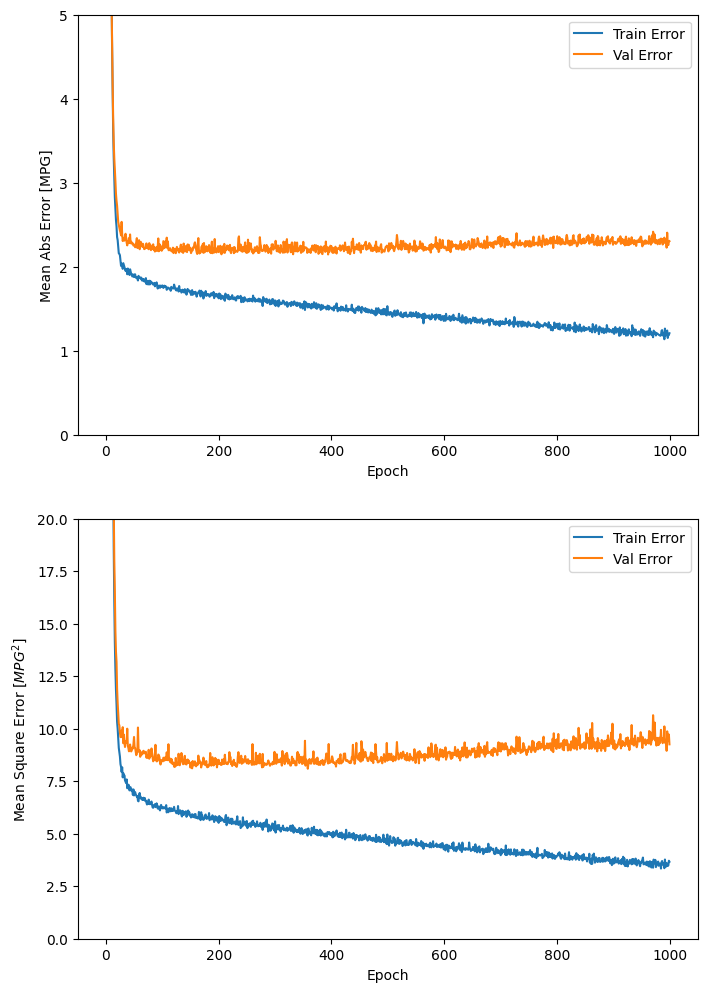

In [22]:
import matplotlib.pyplot as plt


def plot_history(history):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch

    plt.figure(figsize=(8, 12))

    plt.subplot(2, 1, 1)
    plt.xlabel('Epoch')
    plt.ylabel('Mean Abs Error [MPG]')
    plt.plot(hist['epoch'], hist['mae'], label='Train Error')
    plt.plot(hist['epoch'], hist['val_mae'], label='Val Error')
    plt.ylim([0, 5])
    plt.legend()

    plt.subplot(2, 1, 2)
    plt.xlabel('Epoch')
    plt.ylabel('Mean Square Error [$MPG^2$]')
    plt.plot(hist['epoch'], hist['mse'], label='Train Error')
    plt.plot(hist['epoch'], hist['val_mse'], label='Val Error')
    plt.ylim([0, 20])
    plt.legend()
    plt.show()


plot_history(history)

3/3 [==============================] - 0s 1ms/step


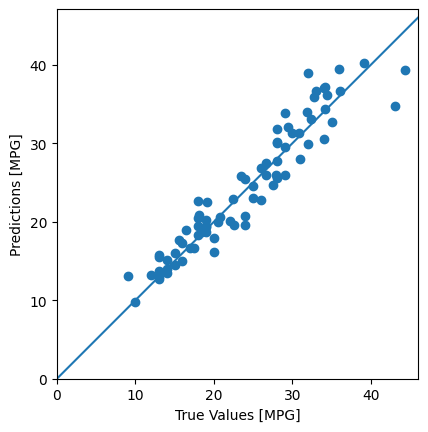

In [23]:
test_predictions = model.predict(normed_test_data).flatten()

plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
plt.axis('equal')
plt.axis('square')
plt.xlim([0, plt.xlim()[1]])
plt.ylim([0, plt.ylim()[1]])
_ = plt.plot([-100, 100], [-100, 100])

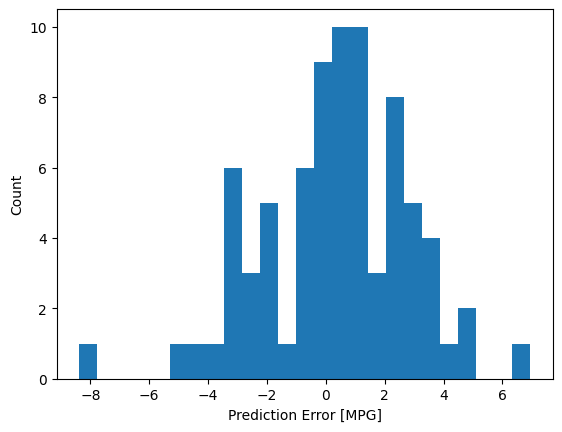

In [24]:
error = test_predictions - test_labels
plt.hist(error, bins=25)
plt.xlabel("Prediction Error [MPG]")
_ = plt.ylabel("Count")